In [ ]:
import numpy as np # this library widely used for numerical computation.
import torch   # it is a framework for building, training, and deploying deep learning models.
import matplotlib.pyplot as plt # this is used for visualization.

In [ ]:
import torch
import torch.nn as nn # It is used for defining, building, and training deep learning models, with pre-defined layers and automatic management of learnable parameters.
import torch.nn.functional as F  # It is more flexible, for neural network operations, such as activation functions, loss calculations, and layer computations, than torch.nn because
import torch.optim as optim  # This module provides optimization algorithms, such as SGD and Adam, to adjust model parameters during training by minimizing the loss function.
import pandas as pd  # It is used for data manipulation, analysis, and cleaning because it provides powerful, flexible, and efficient data structures, such as DataFrames.


In [ ]:
def min_dist(points, res):
    """
    Calculates a 2D tensor with the minimum distance from each pixel to data.

    Inputs:
        * points: a python list of 2D coordinates, normalized in the range [0,1].
        * res: the resolution of the output tensor.
    Returns:
        A res x res square tensor with floating point values corresponding to the
        Euclidean distance to the closest point in points.
    """
    # Convert points into a PyTorch tensor of shape (n_points, 2)
    points = torch.tensor(points)

    # Create a grid of coordinates for the output tensor
    x = torch.linspace(0, 1, res)  # It is used for grid line generation for x-axis
    y = torch.linspace(0, 1, res)  # It is used for grid line generation for y-axis
    grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')  # It creates a 2D coordinate grid for all combinations of x and y values. The indexing='ij' ensures the first dimension corresponds to x (row-major order).
    grid = torch.stack((grid_x, grid_y), dim=-1)  # This is used to combines the x and y coordinates into pairs, creating a grid tensor with shape (res, res, 2)


    # grid[..., None, :] reshapes the grid from (res, res, 2) to (res, res, 1, 2) to allow broadcasting across all points.
    # points[None, None, :, :] reshapes points from (n_points, 2) to (1, 1, n_points, 2) to match the grid's dimensions.
    # (grid[..., None, :] - points[None, None, :, :]) computes the difference between each grid point and each input point.
    # ** 2 means squares the differences.
    # .sum(dim=-1) sums the squared differences along the last dimension (x and y coordinates), yielding squared distances.
    # torch.sqrt() computes the square root to get the Euclidean distance.
    # The resulting tensor distances has shape (res, res, n_points).
    distances = torch.sqrt(((grid[..., None, :] - points[None, None, :, :]) ** 2).sum(dim=-1))

    # Take the minimum distance across all points
    min_distances = distances.min(dim=-1).values

    return min_distances


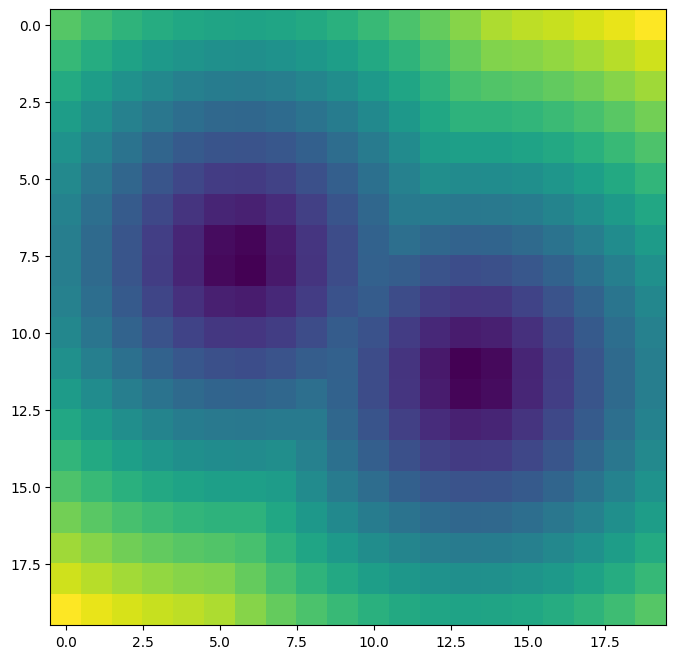

In [ ]:
# Case 1:
distance_to_data = min_dist([[0.4, 0.3], [0.6, 0.7]], 20)
plt.figure(figsize=(8, 8))
plt.imshow(distance_to_data)

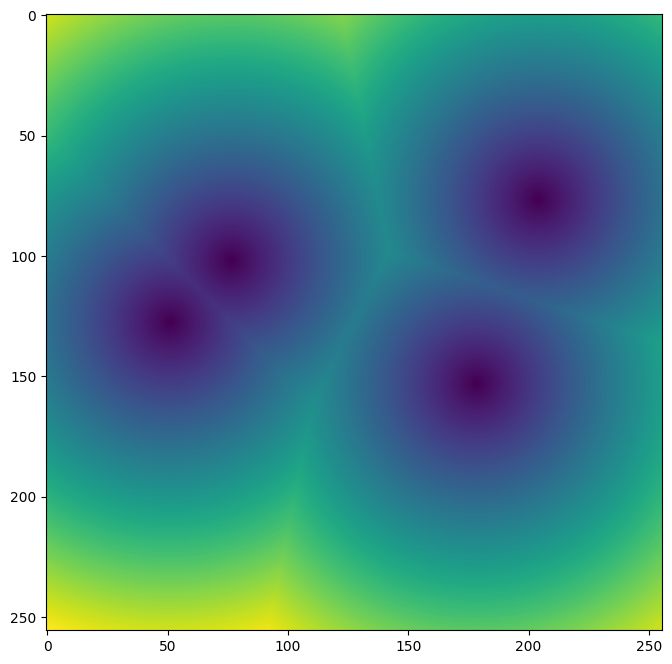

In [ ]:
# Case 2:
distance_to_data = min_dist([[0.4, 0.3], [0.6, 0.7], [0.3, 0.8], [0.5, 0.2]], 256) # Pass the points to the min_dist funtion.
plt.figure(figsize=(8, 8))
plt.imshow(distance_to_data)

### Batched version

As a next step, improve the `min_dist` function to support batches.
The `points` array is now expected to be a tensor with shape [batch_size, num_points, 3], generated by `create_points`.
`min_dist` should return a batch of maps with shape [batch_size, res, res].
Again, make sure to implement `min_dist` using **no for-loops**.
Demonstrate your function output with `batch_size=3` and `num_points=4`.

In [ ]:
def create_points(batch_size, num_points): # This function generates a batch of 2D points with random coordinates and associated random values. The points are organized into a NumPy array of shape [batch_size, num_points, 3].
    coords = np.random.rand(batch_size, num_points, 2)  # Generates random 2D coordinates ([0, 1]) for points.
    # np.random.rand(...) generates random numbers uniformly distributed in the range [0,1)
    # batch_size specifies how many batches of points to generate.
    # num_points specifies the number of points per batch
    # 2 indicates that each point has two coordinates, x and y.

    values = np.random.randint(0, 10, batch_size * num_points).reshape(batch_size, num_points)  # Generates random integer values associated with each point.
    # np.random.randint(0, 10, ...) generates random integers [0,1).
    # batch_size * num_points determines the total number of random values to generate (one for each point in all batches).
    # .reshape(batch_size, num_points) reshapes the flat list of integers into a 2D array: Rows correspond to batches (batch_size) and Columns correspond to points within each batch (num_points).

    values = np.expand_dims(values, 2)  # Prepares the values array for concatenation with the coords array.
    # coords has shape [batch_size, num_points, 2], so adding a third dimension to values ensures both arrays have compatible shapes for concatenation.

    points = np.concatenate((coords, values), axis=2)  # Combines the x,y coordinates (coords) with their associated random values (values) into a single array. Shape: [batch_size, num_points, 3]

    return points

In [ ]:
def min_dist(points, res):
    """
    Calculates a 3D tensor with the minimum distance from each pixel to data.

    Inputs:
        * points: a numpy array of 2D coordinates and point values, normalized to
                  be in the range [0,1]. The expected shape is [B, P, 3].
        * res: the resolution of the output tensor.
    Returns:
        A tensor with shape [B, res, res], where each pixel value corresponds to
        the Euclidean distance to the closest point in points.
    """
    # Converts the input points (a NumPy array) into a PyTorch tensor for efficient computation.
    points = torch.tensor(points, dtype=torch.float32)
    # torch.tensor(points) creates a tensor from the points NumPy array.
    # dtype=torch.float32 ensures the data type is 32-bit floating point, suitable for numerical computations.


    # Extract the coordinates (ignore the third column for distance calculation)
    coords = points[..., :2]
    # points[..., :2] selects all dimensions (...) except the last, where it selects only the first two components ([x,y]).

    # Create a grid of coordinates for the output tensor
    x = torch.linspace(0, 1, res)  # Grid for x-axis
    y = torch.linspace(0, 1, res)  # Grid for y-axis
    grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')  # Shape: [res, res]
    grid = torch.stack((grid_x, grid_y), dim=-1)  # Combines the y-coordinate grids into a single tensor.Shape: [res, res, 2].

    # Add batch dimension to the grid to align with points tensor
    grid = grid.unsqueeze(0)  # grid.unsqueeze(0) inserts a new dimension at index 0. This transforms the shape of grid from [res, res, 2] to [1, res, res, 2].

    # Compute distances from each grid point to each input point in the batch
    # Shape of coords is [B, P, 2], shape of grid is [1, res, res, 2]
    distances = torch.sqrt(((grid[..., None, :] - coords[:, None, None, :, :]) ** 2).sum(dim=-1))  # Already explain elaborately.

    # Take the minimum distance across all points in the batch
    min_distances = distances.min(dim=-1).values  # Already explain elaborately.

    return min_distances

In [ ]:
# Testing the function
# Defines the size of the batch and the number of points in each batch.
batch_size = 3 # The batch contains 3 sets of points.
num_points = 4 #  Each set in the batch contains 4 points.


# Calls the create_points function to generate random test points for the batch.
points = create_points(batch_size, num_points)
print("Points Shape:", points.shape)  # Prints the shape of the generated points array to verify it matches the expected shape, Should be [3, 4, 3]

res = 25  # Sets the resolution of the output distance maps.
distances = min_dist(points, res) # Calls the min_dist function to compute the distance maps for the points in the batch.
print("Output Shape:", distances.shape)  # Verifies that the output from min_dist has the expected shape, Should be [3, 25, 25]

Points Shape: (3, 4, 3)
Output Shape: torch.Size([3, 25, 25])


   Input :
  * points: a numpy array of 2D coordinates and point values, normalized to
    be in the range [0,1]. The expected shape is [B, P, 3].
  * res: the resolution of the output tensor.  
   
Returns:  
  * A (res x res) square tensor with floating point values corresponding to the
    euclidean distance to the closest point in points. The return tensor
    shape is [B, res, res].  

While I used the shape [3, P, 3] and res as input and obtained the shape [3, 25, 25] as output which veifies the correctness of the function.


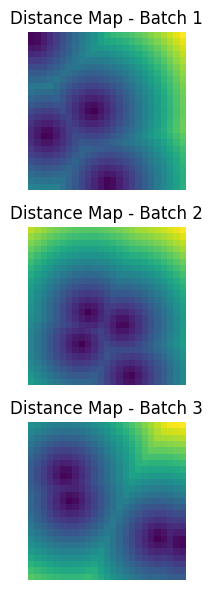

In [ ]:
# Visualizing the Distance Maps
fig, axs = plt.subplots(batch_size, 1, figsize=(6, 6)) # Creates a grid of subplots for visualizing the distance maps.

for i in range(batch_size): # Iterates through each batch to plot its corresponding distance map.
    axs[i].imshow(distances[i].numpy(), cmap='viridis')  # Displays the distance map for the i-th batch on the i-th subplot. Convert to NumPy for visualization
    axs[i].set_title(f'Distance Map - Batch {i+1}') # Sets the title of the i-th subplot.
    axs[i].axis('off') # Turns off the axis for the i-th subplot to make the visualization cleaner.

plt.tight_layout() # Adjusts the spacing between subplots for better layout.
plt.show()